## TODO
1. Come up with a standard lat/lon scheme to record from
    1. Set option for passing no coordinates and determining on the fly.

# Air Quality Exploratory Data Analysis I
## Overview
- Load cleaned air quality data that was previously generated
- Add a `neighborhood` column that shows which neighborhood the measurements are in
- Look at the geospatial distribution of these events
    - Where are most happening?
    - Which areas have the most closed/open requests?
    - Which areas have receive attention the fastest?

In [1]:
# Standard tools for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Tools specific for geospatial data analysis
from mpl_toolkits.basemap import Basemap
import shapely
from shapely.geometry import shape, mapping, Point, Polygon
import geopandas as gpd
import geojsonio
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

# Tools from the Python Standard Library
import os
import re

from IPython.display import display
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
RESULTSDIR = '../results/'
!ls $RESULTSDIR

01-air_quality.h5      01-neighborhoods.h5    02-service_requests.h5
01-crime.h5            01-service_requests.h5


In [3]:
air_quality = pd.read_hdf(RESULTSDIR + '01-air_quality.h5')
air_quality.head()

,Longitude,Latitude,Value,Pollutant,region
0,-122.322594,37.806781,24.000000,NO,WestOak
1,-122.322310,37.806150,19.775000,NO,WestOak
2,-122.322301,37.806420,19.974999,NO,WestOak
3,-122.322299,37.805880,15.208696,NO,WestOak
4,-122.322267,37.806689,26.887681,NO,WestOak


In [ ]:
# from plotting import city_heat_map, neighborhood_heat_map

## 1. Check out a simple heat map of pollution

In [49]:
def city_heat_map(data, col, coords=None, label=None, ax=None, xpixels=2000):
    """
    Plot a heat map on the neighborhoods listed in the data.
    
    Parameters
    ----------
    data : GeoDataFrame
        GeoDataFrame containing neighborhoods and their associated geometries.
    col : str
        String referring to a column name in data.
    coords : dict, default=None
        Dict with keys llcrnrlon, llcrnrlat, urcrnrlon, and urcrnrlat. If set to None, use max/min from 'Longitude'
        and 'Latitude' columns to determine the region.
    ax : matplotlib axis, default=None
        Plot the heat map to an axis ax. If set to None, a new figure and axis is created
    xpixels : int
        Resolution of the base map. Increasing this number increases the amount of detail contained in the base map.
        
    Returns
    -------
    Heat map of col overlayed on a satellite image.
    
    """
    
    # Create a canvas if an axis isn't provided
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        axis = fig.add_axes([0.,0.,1.,1.])
    else:
        fig = ax.get_figure()
        axis = ax
        
    if coords is None:
        llcrnrlon = data['Longitude'].min()
        llcrnrlat = data['Latitude'].min()
        urcrnrlon = data['Longitude'].max()
        urcrnrlat = data['Latitude'].max()   
    else:
        llcrnrlon=coords['llcrnrlon']
        llcrnrlat=coords['llcrnrlat']
        urcrnrlon=coords['urcrnrlon']
        urcrnrlat=coords['urcrnrlat']

    # Create a map to overlay data on
    bm = Basemap(epsg=3493,
                 llcrnrlon=llcrnrlon,
                 llcrnrlat=llcrnrlat,
                 urcrnrlon=urcrnrlon,
                 urcrnrlat=urcrnrlat,
                 ax=axis)

    bm.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=xpixels)
    
    # Get the coordinates for plotting
    x, y = bm(data['Longitude'].values, data['Latitude'].values)

    
    sc = axis.scatter(x,
                      y,
                      c=data[col],
                      cmap='inferno',
                      vmin=data[col].min(),
                      vmax=data[col].max(),
                      marker='.',
                      lw=0)

    # Create a color bar
    cax = fig.add_axes([1.05, 0.1, 0.03, 0.8])
    cbar = fig.colorbar(sc, cax=cax)

    if label is None:
        label = col

    cbar.set_label(label, rotation=270, labelpad=40, fontsize=20)
    
    if ax is None:
        return fig, ax

Let's test this out:

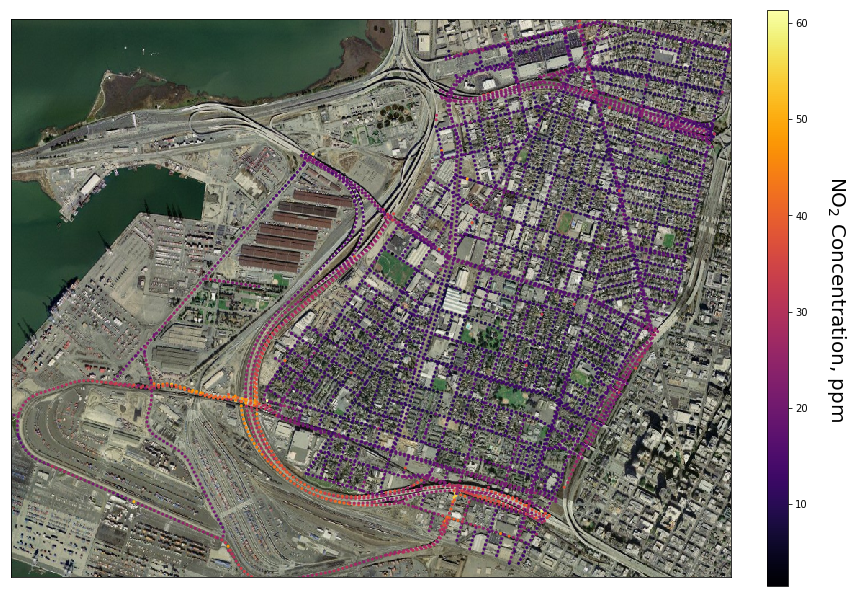

In [51]:
f, ax = city_heat_map(data=air_quality[(air_quality['Pollutant'] == 'NO2') & (air_quality['region'] == 'WestOak')],
                      col='Value',
                      coords=None,
                      label='NO$_2$ Concentration, ppm',
                      xpixels=1000)

In [40]:
air_quality['Pollutant'].unique()

array(['NO', 'NO2', 'BC'], dtype=object)